# Setup

In [14]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import HTML,clear_output
from importlib import reload
import time

import itertools
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
import plotly.graph_objects as go

from importData import import_all,generate_diffuse_tether_trajectories
import displayData
import trajAnalysis
import bayesianTools
from model_utils import GenerationMode
import model
from utils import notebook_setup_widgets,accuracy_of_hidden_paths
import tests

from scipy.stats import loguniform
from config import OUTPUTS_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate trajectories

In [2]:
regimes_table = np.array([
    [1, 10, 2*10**3, 2*10**3, 10**5], #1
    [1, 2, 2*10**3, 2*10**3, 10**5], #2
    [1, 1, 2*10**3, 2*10**3, 10**5], #3
    [1, 10, 50, 50, 10**5], #4
    [1, 10, 50, 100, 10**5], #5
    [1, 10, 100, 50, 10**5], #6
    [1, 1, 5, 5, 10**5], #7
    [1, 1, 5, 10, 10**5], #8
    [1, 1, 10, 5, 10**5], #9
])

In [65]:
N_particle=1
D = 1.
regime = regimes_table[0]
A,dt,T_stick,T_unstick,T = regime
T = 10**4
A *=D
N_steps = int(T/dt)
df, model_params = tests.generateSynthTrajs(N_steps, N_particle, dt, T_stick, T_unstick, D, A)
X_arr_list = bayesianTools.extract_X_arr_list_from_df(df)
dt_list = bayesianTools.extract_dt_list_from_df(df)

In [101]:
S_arr, X_tether_arr, viterbi_path_log_likelihood,L_mat,S_mat = bayesianTools.viterbi_algorithm(X_arr_list[0], model_params)

In [102]:
L_mat[:4,:4,0]

array([[  0.       ,  -4.8436875, -10.479829 , -15.319609 ],
       [  0.       ,  -1.9446812, -19.718342 , -36.352486 ],
       [  0.       , -10.142014 , -27.935774 , -44.624687 ],
       [  0.       ,   0.       , -15.778154 , -17.64467  ]],
      dtype=float32)

In [91]:
L_mat[:4,:4]

array([[  0.       ,  -4.8436875, -10.479829 , -15.319609 ],
       [  0.       ,  -1.9446812, -19.718342 , -36.352486 ],
       [  0.       , -10.142014 , -27.935774 , -44.624687 ],
       [  0.       ,   0.       , -15.778154 , -17.64467  ]],
      dtype=float32)

In [92]:
orig_S_arr, orig_X_tether_arr, orig_viterbi_path_log_likelihood,orig_L_mat,orig_S_mat = S_arr, X_tether_arr, viterbi_path_log_likelihood,L_mat,S_mat

In [87]:
output = bayesianTools.em_viterbi_optimization(X_arr_list, dt_list, T_stick,T_unstick,D,A,
                                               is_parallel=False, verbose=True)
params_by_iter, L_by_iter, S_arr_list, X_tether_arr_list = output

Initial parameters are [2.00e+03, 2.00e+03, 1.00e+00, 1.00e+00]
Starting iteration 0 - E step
Done with iteration 0 - M step
Current parameter estimates are [6.54e+01, 8.97e+01, 6.05e-01, 9.66e-01]
Starting iteration 1 - E step
Done with iteration 1 - M step
Current parameter estimates are [4.37e+01, 7.52e+01, 6.84e-01, 9.41e-01]
Starting iteration 2 - E step
Done with iteration 2 - M step
Current parameter estimates are [4.32e+01, 7.57e+01, 6.91e-01, 9.52e-01]


In [100]:
L_by_iter

array([-3536.22998047, -3532.47265625])

In [99]:
output = bayesianTools.em_viterbi_optimization(X_arr_list, dt_list, T_stick,T_unstick,D,A,
                                               is_parallel=False, verbose=True)
params_by_iter, L_by_iter, S_arr_list, X_tether_arr_list = output

Initial parameters are [2.00e+03, 2.00e+03, 1.00e+00, 1.00e+00]
Starting iteration 0 - E step
Done with iteration 0 - M step
Current parameter estimates are [1.24e+03, 7.51e+03, 9.59e-01, 9.30e-01]
Starting iteration 1 - E step
Done with iteration 1 - M step
Current parameter estimates are [1.24e+03, 7.51e+03, 9.59e-01, 9.30e-01]


In [80]:
L_by_iter

array([-3536.22998047, -3532.47265625])

In [22]:
print(np.round(model.model_get_optimal_parameters(dt,df.state.values,df[["x","y"]].values,df[["x_tether","y_tether"]].values),2))
print(np.round([T_stick,T_unstick,D,A],2))
print(np.round(output[0][-1],2))

[5.95e+02 8.80e+03 1.11e+00 9.90e-01]
[2.e+03 2.e+03 1.e+00 1.e+00]
[5.95e+02 8.80e+03 1.11e+00 9.90e-01]


In [23]:
vit_path = output[2][0]
tru_path = df.state.values
vit_params = model.pack_model_params(*np.hstack([output[0][-1],[dt]]))
tru_params = model.pack_model_params(*[T_stick,T_unstick,D,A,dt])
def likelihood_path_params(path,params):
    return model.model_trajectory_log_probability(
        path,X_arr=X_arr_list[0],model_params=params) / N_steps

tt_log_likelihood = likelihood_path_params(tru_path,tru_params)
print("Path/params minus TT")
print(f"VV: {likelihood_path_params(vit_path,vit_params)-tt_log_likelihood:.7f}")
print(f"VT: {likelihood_path_params(vit_path,tru_params)-tt_log_likelihood:.7f}")
print(f"TV: {likelihood_path_params(tru_path,vit_params)-tt_log_likelihood:.7f}")

Path/params minus TT
VV: 0.0036943
VT: 0.0000000
TV: 0.0036943


In [55]:
np.argpartition(np.random.permutation(10),4)

array([1, 4, 7, 5, 9, 3, 6, 2, 8, 0], dtype=int64)

In [60]:
A[np.unravel_index(5,A.shape)]

-1.259531516954984

In [51]:
A = np.random.normal(size=(3,4,3))
np.vstack(np.where(A[:,:,0]>0)).T

array([[0, 0],
       [0, 2],
       [0, 3],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 2],
       [2, 3]], dtype=int64)

In [24]:
est_model_params = model.pack_model_params(*np.hstack([output[0][-1],[dt]]))

<IPython.core.display.Javascript object>


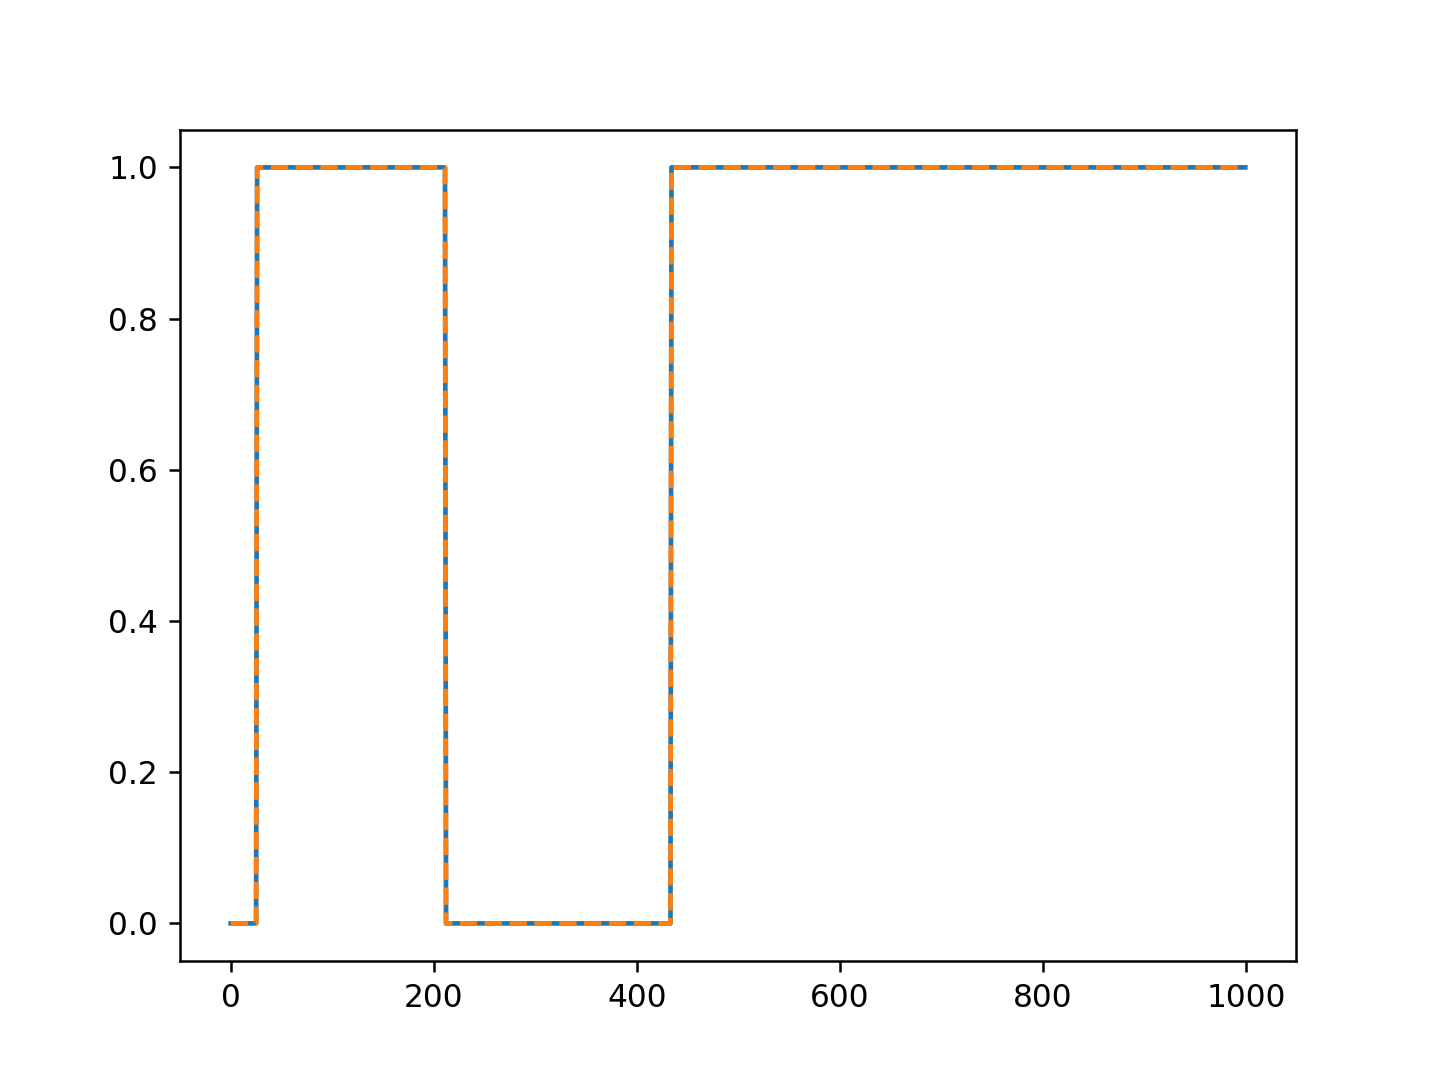

In [79]:
fig,ax=plt.subplots()
plt.plot(df.state.values,"-")
plt.plot(S_arr_list[0],"--")
# _=ax.set_title(f"Accuracy: {100*acc : .2f}%")

In [27]:
startAtOrigin=False
if startAtOrigin:
    plotly_df=trajAnalysis.shift_traj_to_origin(df)
else:
    plotly_df = df.copy()
plotly_df.y *=-1

plotly_df["particle_state"] = plotly_df.particle.astype(str)+"_"+plotly_df.state.astype(str)
fig = px.line(plotly_df, x="x", y="y", color='particle_state',hover_data=['frame'],color_discrete_sequence=px.colors.qualitative.D3,)
fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
fig.show()

## MSD Plot:

In [ ]:
default_groupby = "experiment"
if "MSD_fig" in locals() : plt.close(MSD_fig)
MSD_fig, MSD_ax = plt.subplots(figsize=(6, 4))
@interact(Log_Scale=True,group_by=["experiment","particle"],max_lagtime=(100,2000,10),N_sample_points = (2,101,1),equal_weight_per_particle=True)
#def update(group_by="experiment",Log_Scale=True,equal_weight_per_particle=True,step_lagtime=5,max_lagtime=100,):
def update(group_by=default_groupby,Log_Scale=False,equal_weight_per_particle=True,N_sample_points=21,max_lagtime=1000,):
    MSD_ax.cla()
    displayData.plot_MSD(df,isdfPadded=True, lagtime=np.unique(np.round(np.logspace(0,np.log10(max_lagtime),N_sample_points))), group_by=group_by, logscale=Log_Scale, ax=MSD_ax,eqParticleWeight=equal_weight_per_particle)
    MSD_ax.grid(True)

## Displacement Distribution $G(\Delta x,\Delta t)$:

In [ ]:
# set up plot
if "G_fig" in locals() : plt.close(G_fig)
G_fig, G_ax = plt.subplots(figsize=(6, 4))

dt_default = 30
xlim_default = 5.

@interact(dt=(1, min(200,df.frame.max()-1), 1),semiLogScale=True,direction=["xy", "x", "y"],group_by=["experiment","particle"],x_lim=(1., 30., 0.5),equal_weight_per_particle=True, clearAxes = True)
def update(dt=dt_default,x_lim=xlim_default,group_by="experiment",direction="xy",semiLogScale=True,equal_weight_per_particle=True,clearAxes = True):
    if clearAxes: G_ax.cla()        
    displayData.plot_G_dx_dt(df
                             ,isdfPadded=True, direction=direction, group_by=group_by, dt=dt, return_stats=False,semilogscale=semiLogScale,ax=G_ax,equal_particle_weight=equal_weight_per_particle)
    G_ax.set_xlim([-x_lim,x_lim])
    G_ax.set_ylim([1e-6,1e1]) if semiLogScale else G_ax.set_ylim([0,2.])   
    G_ax.grid(True)
    
#     sns.move_legend(G_ax,"lower left")
#     plt.setp(G_ax.get_legend().get_texts(), fontsize='7')  # for legend text
#     plt.setp(G_ax.get_legend().get_title(), fontsize='8')  # for legend title
